# Connect Intensive - Machine Learning Nanodegree
# Lesson 06: Clustering and Dimensionality Reduction
# Part 02: PCA Mini Project

## Objectives
  - Perform Principal Component Analysis (PCA) on a large set of features to explain as much of the variance as possible in the data using a smaller set of features (reducing the dimensionality).
  - Recognize differences between `train_test_split()` and `StratifiedShuffleSplit()` when creating training and testing sets.
  - Introduce the `class_weight` parameter for `SVC()`, to see how correctly predicting targets from a smaller class size can be weighted more heavily.
  - Visualize the eigenfaces (orthonormal basis of components) that result from PCA.
  
## Prerequisites
  - You should have the following python packages installed:
    - [matplotlib](http://matplotlib.org/index.html)
    - [numpy](http://www.scipy.org/scipylib/download.html)
    - [sklearn](http://scikit-learn.org/stable/install.html)
  - For context, you should also have watched Sebastian & Katie's Udacity video lectures on PCA prior to working through this notebook.
    
## Acknowledgements
  - This is a copy of [Nick Hoh's IPython notebook for PCA Mini project](https://github.com/nickypie/ConnectIntensive). _ I have modified it to work with sklearn v0.17. _
  - The content of this notebook builds on the code from [pca/eigenfaces.py](https://github.com/udacity/ud120-projects/blob/master/pca/eigenfaces.py) from the [**ud120-projects**](https://github.com/udacity/ud120-projects) repo, and derives from [an eigenfaces/SVM example in the sklearn documentation](http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html)

## PCA Mini-Project

This Jupyter Notebook is intended to provide a friendly guide through the "PCA Mini-Project" lesson... but if you're feeling pretty confident about your Python skills, consider going off-script! Try to work through the lesson on your own -- you may encounter some snags, and you can always refer back to this Notebook if you need a little push forward.

Hopefully you have watched Sebastian and Katie's video lectures on Principal Component Analysis -- if you haven't, I recommend catching up on those video lectures before tackling this project. That way, you will get the context of how and why we are using PCA to reduce the dimensionality of our dataset.

## Labeled Faces in the Wild

The dataset for this mini-project comes from ["Labeled Faces in the Wild"](http://vis-www.cs.umass.edu/lfw/) or LFW, a database of more than 13,000 face photographs designed for studying the problem of unconstrained face recognition. We are going to use the **funneled** dataset, which comes from the following paper:

> Gary B. Huang, Vidit Jain, and [Erik Learned-Miller](http://people.cs.umass.edu/~elm/).  
[**Unsupervised Joint Alignment of Complex Images**](http://vis-www.cs.umass.edu/papers/iccv07alignment.pdf)  
*International Conference on Computer Vision (ICCV), 2007.*

If you're curious, section 2 of the paper (Background) describes the preprocessing steps of [congealing](http://vis-www.cs.umass.edu/congeal.html) and funneling to align images in the dataset.

The original source of this PCA demo comes from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html).

**Run** the cell below to import useful libraries and modules for this Jupyter notebook. We will use quite a few different functions from `sklearn` -- some we've seen before and others that are new.

In [2]:
from time import time
import logging

# Display progress logs on stdout
# (useful to monitor progress while downloading LFW data)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

%matplotlib inline

print("Finished loading all libraries")

Finished loading all libraries


**Run** the cell below to download the data using [the `sklearn` function `fetch_lfw_people()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html). The LFW data is ~200MB, so the download may take a while. The data will be loaded into the data dictionary `lfw_people`. The dictionary contains several items:
  - `lfw_people.DESCR`: A string -- a short description of the data dictionary.
  - `lfw_people.data`: A 2-dimensional numpy array (`dtype=float32`) with shape `(n_samples, n_features)`
    - Each entry in the array is a value ranging from 0.0 to 255.0, denoting the 8-bit [grayscale](https://en.wikipedia.org/wiki/Grayscale) value of each pixel.
    - `n_samples` is the total number of images, the instances/inputs in the dataset.
    - `n_features` is the number of pixels per image, the features of the dataset.
  - `lfw_people.images`: A 3-dimensional numpy array (`dtype=float32`) with shape `(n_samples, height, width)`.
    - `images` is just `data` reshaped, so that `height` $\times$ `width` = `n_features`
  - `lfw_people.target` : A 1-dimensional numpy array (`dtype=int64`) of length `n_samples`, the labels of each image
  - `lfw_people.target_names`: A 1-dimensional numpy array of length `n_classes`
  
**Notes:** Sometimes [the pillow module](https://python-pillow.org/) (which is being used in this example) can cause trouble with this notebook. If you get an error related to the `fetch_lfw_people()` command, try the following:

``pip install --upgrade PILLOW``

If you run into a different error, note that there are changes in one of the parameters for the SVC function called on line 94 of pca/eigenfaces.py. For the `class_weight` parameter, the argument string "auto" is a valid value for sklearn version 0.16 and prior, but will be depreciated by 0.19. If you are running sklearn version 0.17 or later, the expected argument string should be "balanced". If you get an error or warning while running the [**ud120-projects**](https://github.com/udacity/ud120-projects) code in [pca/eigenfaces.py](https://github.com/udacity/ud120-projects/blob/master/pca/eigenfaces.py), make sure that you have the correct argument on line 98 of that file, that matches your installed version of sklearn.

In [3]:
# Download the data, if not already on disk, and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
print("Finished loading faces for this exercise.")

2016-11-27 14:59:16,329 Loading LFW people faces from C:\Users\Zeta.Khundkar\scikit_learn_data\lfw_home


Finished loading faces for this exercise.


Above, in the call to `fetch_lfw_people()`, we set the parameter `min_faces_per_person` to 70. This parameter ensures that the extracted dataset will only retain pictures of people that have at least 70 different pictures. The `resize` parameter of 0.4 scales each image to 40% of its original size, so that the dataset takes up less working memory.

**Run** the cell below to see the names of the people in the `lfw_people` dataset, with their corresponding target IDs.

In [4]:
# Print the indices and names of the people in the lfw_people dataset
for idx, name in enumerate(lfw_people.target_names):
    print("{}: {}".format(idx,name))

0: Ariel Sharon
1: Colin Powell
2: Donald Rumsfeld
3: George W Bush
4: Gerhard Schroeder
5: Hugo Chavez
6: Tony Blair


Let's continue exploring the `lfw_people` data dictionary! **Run** the cell below to extract the shape information (number of samples, number of features, image height and width) from `lfw_people.images` and `lfw_people.data`. You will see a summary of the dataset: the numbers of samples (images), features (pixels), and classes (targets). You will also see the number of images per target in the dataset -- note that we have many more images of certain targets!

In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2-dimensional data directly
# (relative pixel positions info will be ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the target ID of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# print a summary of the total dataset size
print("Total dataset size:")
print("  n_samples  : {:>4}".format(n_samples))
print("  n_features : {:>4}".format(n_features))
print("  n_classes  : {:>4}\n".format(n_classes))

# print the number of images for each target in the dataset
print("Images per Target:")
for idx, name in enumerate(lfw_people.target_names):
    print("  {:<18}: {:>3} images".format(name,np.sum(lfw_people.target == idx)))

Total dataset size:
  n_samples  : 1288
  n_features : 1850
  n_classes  :    7

Images per Target:
  Ariel Sharon      :  77 images
  Colin Powell      : 236 images
  Donald Rumsfeld   : 121 images
  George W Bush     : 530 images
  Gerhard Schroeder : 109 images
  Hugo Chavez       :  71 images
  Tony Blair        : 144 images


**Run** the cell below to split the data into training and testing (validation) sets. Note that we choose to use the function [`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) instead of [`StratifiedShuffleSplit()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html), so there's no guarantee that our training and testing sets will have the same proportion of each target or class. This cell will check to see how evenly `train_test_split()` partitions the data between training and testing set for each target. As a comparison, we also split the data using `StratifiedShuffleSplit()` and check the percentages of each target in the dataset.

In [6]:
# Split into a training and testing set using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Summarize the proportions of each label in the training and testing sets
print("train_test_split() results:")
print("{:>28}{:>8}".format("train","test"))
for idx, name in enumerate(lfw_people.target_names):
    print("  {:<18}: {:6.1f}% {:6.1f}%"\
          .format(name,\
                  np.sum(y_train == idx) * 100.0 / len(y_train),\
                  np.sum(y_test == idx) * 100.0 / len(y_test)))
    
# Compare to training and testing set using StratifiedShuffleSplit() v0.17
sss = StratifiedShuffleSplit(y, n_iter=1, test_size=0.25, random_state=42)

## in v.017, StratifiedShuffleSplit returns an iterator. If you are not familiar with how  
## iterators work or why they are used, here is a brief explanation:
##    A python iterator is an object you can loop over using a for _ in <iterator. syntax.
##    It is a little different from a list or tuple in that the iterator will not provide
##    the list or tuple of items as a value -- you will have to write the loop to get the values
##    The advantage of this is that an iterator can provide a very large list without
##    having to allocate the memory needed to store the elements. When you write the loop,
##    you end up allocating the memory and references you need for your task.
##
##    The for loop below show a common way to use an iterator.
##    I added a counter in the loop so we can tell how many times the loop is iterated.
##    You can remove the # in front of the print statement to see the result

iter_count=0
for train_index_sss, test_index_sss in sss:
    X_train_sss, X_test_sss = X[train_index_sss], X[test_index_sss]
    y_train_sss, y_test_sss = y[train_index_sss], y[test_index_sss]

#print "\nWent through loop {} times".format(iter_count)    

# Summarize the proportions of each label in the training and testing sets
print("\nStratifiedShuffleSplit() comparison:")
print("{:>28}{:>8}".format("train","test"))
for idx, name in enumerate(lfw_people.target_names):
    print("  {:<18}: {:6.1f}% {:6.1f}%"\
          .format(name,\
                  np.sum(y_train_sss == idx) * 100.0 / len(y_train_sss),\
                  np.sum(y_test_sss == idx) * 100.0 / len(y_test_sss)))

train_test_split() results:
                       train    test
  Ariel Sharon      :    6.6%    4.0%
  Colin Powell      :   18.2%   18.6%
  Donald Rumsfeld   :    9.7%    8.4%
  George W Bush     :   39.8%   45.3%
  Gerhard Schroeder :    8.7%    7.8%
  Hugo Chavez       :    5.8%    4.7%
  Tony Blair        :   11.2%   11.2%

StratifiedShuffleSplit() comparison:
                       train    test
  Ariel Sharon      :    6.0%    5.9%
  Colin Powell      :   18.3%   18.4%
  Donald Rumsfeld   :    9.4%    9.3%
  George W Bush     :   41.2%   41.1%
  Gerhard Schroeder :    8.5%    8.4%
  Hugo Chavez       :    5.5%    5.6%
  Tony Blair        :   11.2%   11.2%


Looking at the results of `train_test_split()`, we see that sometimes a label is slightly over-represented in the training set (*e.g.* for Ariel Sharon or Donald Rumsfeld). In contrast, the `StratifiedShuffleSplit()` method aims to match the representation of each label in the training and testing set as closely as possible. However, for the most part, there is not a significant difference in each label's representation when using `train_test_split()` -- so we'll proceed with the `train_test_split()` splits.

## Principal Component Analysis

The goal of [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is to describe the maximal amount of variance in a dataset by the fewest number of composite features. PCA as a concept is a lot easier to understand when seen, so for cool interactive visualizations on Principal Component Analysis, [check this out](http://setosa.io/ev/principal-component-analysis/) -- you can drag points in a dataset around in a plane and see the resulting axes for PCA on that dataset!

**Run** the cell below to perform [Principal Component Analysis with `sklearn`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on the training set of images to find the *eigenfaces*, or the orthonormal basis resulting from PCA.

**Note:** There's a little background on [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) and [Randomized SVD](https://research.facebook.com/blog/fast-randomized-svd/) that may be useful or interesting to read here... but it's not necessary to fully understand SVD to appreciate the results of PCA.

In [7]:
# Compute a PCA (eigenfaces) on the face dataset -- sklearn 0.17
# (here, we treat the images as an unlabeled dataset):
# unsupervised feature extraction / dimensionality reduction

# How many components from PCA to keep?
n_components = 150

# Perform PCA on the training data set, keep track of elapsed time.
print("Extracting the top {} eigenfaces from {} faces".format(n_components, X_train.shape[0]))
t0 = time()

# NOTE: in sklearn v0.17 and earlier, there was a separate method,
#   sklearn.decomposition.RandomizedPCA()
# that performed randomized Singular Value Decomposition (SVD)
#
# For sklearn v0.18 onward, the parameter svd_solver="randomized"
# in PCA() will do this -- no need for a separate method.
pca = RandomizedPCA(n_components=n_components, \
          whiten=True).fit(X_train)
print("done in {:0.3f}s".format(time() - t0))

# Reshape the PCA components based on the image dimensions.
eigenfaces = pca.components_.reshape((n_components, h, w))


print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in {:0.3f}s".format(time() - t0))


Extracting the top 150 eigenfaces from 966 faces
done in 0.733s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.077s


## Explained Variance Ratio

Now that we've conducted PCA on the training dataset, we can see how much of the variance in the dataset is explained by each eigenface (or each component of the orthonormal basis). The components are ordered by ratio of explained variance in descending order, and after conducting PCA this information is stored in the attribute `pca.explained_variance_ratio_`. **Run** the cell below to print the explained variance percentage from the first five eigenfaces, and the total explained variance percentage of all 150 eigenfaces.

In [8]:
for idx, var in enumerate(pca.explained_variance_ratio_[:5]):
    print("Eigenface {} explains {:5.2f}% of the variance.".format(idx+1, var*100.0))
    
print("\nIn total, the first {} eigenfaces explain {:5.2f}% of the variance."\
      .format(len(pca.explained_variance_ratio_),\
              100.0*np.sum(pca.explained_variance_ratio_)))

Eigenface 1 explains 19.35% of the variance.
Eigenface 2 explains 15.12% of the variance.
Eigenface 3 explains  7.08% of the variance.
Eigenface 4 explains  5.95% of the variance.
Eigenface 5 explains  5.16% of the variance.

In total, the first 150 eigenfaces explain 95.64% of the variance.


## What does an eigenface look like?

Now we're going to define a couple helper functions, `plot_gallery()` and `title()`, to help us see some sample faces from the test set, and visualize the first few eigenfaces to see what features explain the greatest amount of variance in the dataset.

**Run** the cell below to define the two helper functions `plot_gallery()` and `title()` -- do you follow what each line of code does in the two helper functions?

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: {}\ntrue:      {}'.format(pred_name, true_name)

Let's put the helper functions to work! **Run** the cell below to visualize the first few faces from the test set, labeled with the predicted and actual classes. How did our optimal classifier do on these faces?

Now this part is a little spooky (maybe we should have covered this lesson during Halloween). **Run** the cell below to visualize the first few eigenfaces (components of the orthonormal basis that maximally explains the variance in the dataset). You should see some ghostly apparitions that resemble faces, all arising from PCA!

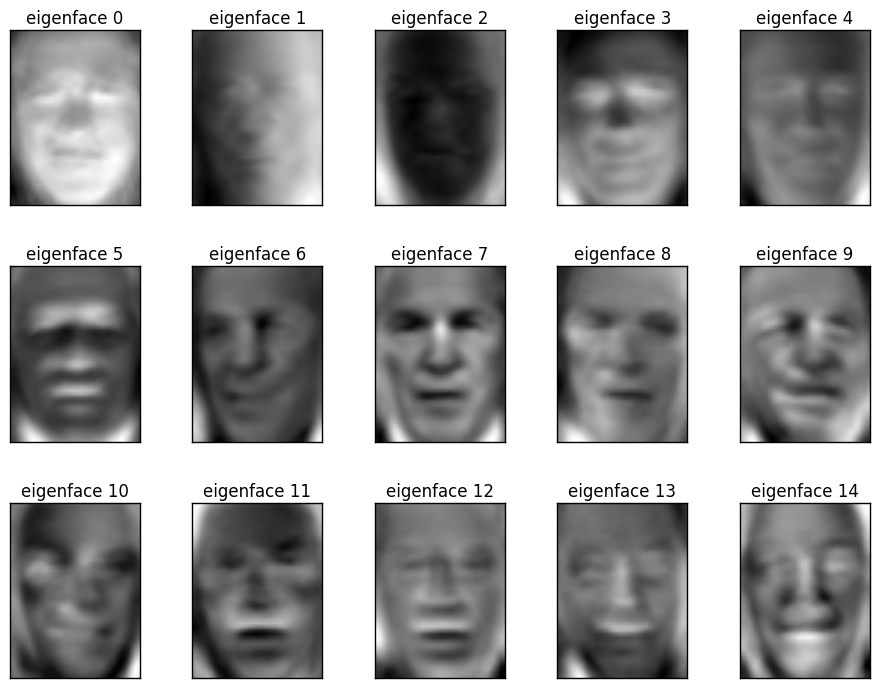

In [10]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface {}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

##  We will now run a Support Vector Classifier using a training set of the PCA-transformed images 

### Refining the accuracy score:  `class_weight`

We saw earlier in this notebook that the different targets or classes have different representation, so [the accuracy score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) might not be the best measure of how good a predictive model is. For example, a predictive model where the prediction is always "Ariel Sharon" would have an accuracy score of about 6% on our dataset, while a predictive model where the prediction is always "George W Bush" would have an accuracy score of about 41% on our dataset -- but the second model isn't necessarily any better! To deal with this problem, we can adjust the `class_weight` parameter in `SVC()`, so that the model score improves by different amounts depending on the class of the that targets are accurately classified. For a more detailed explanation of the `class_weight` parameter, you could [read the `SVC()` documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), or check out [this stackoverflow post](http://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work) -- I found the response by Andreas Mueller helpful.

The cell below has the formula for computing the weights when setting the `class_weight` parameter in `SVC()` to `"balanced"`. **Run** the cell below to display the weights for each class or target, along with the number of instances of each target. This cell shows that rarer classes or targets are weighted more heavily -- it's more important for the classifier to get those targets correct!

In [11]:
weights = n_samples*1.0 / (n_classes * np.bincount(y_train))
print("{:<23}{:<8}{:<6}".format("Target Name","Weight","Count"))
for idx, name in enumerate(lfw_people.target_names):
    print("  {:<18}: {:6.2f} {:>6}".format(name, weights[idx], np.sum(y_train == idx)))

Target Name            Weight  Count 
  Ariel Sharon      :   2.88     64
  Colin Powell      :   1.05    176
  Donald Rumsfeld   :   1.96     94
  George W Bush     :   0.48    384
  Gerhard Schroeder :   2.19     84
  Hugo Chavez       :   3.29     56
  Tony Blair        :   1.70    108


Now that we understand how the `class_weight` parameter adds weight to the rarer classes, we can use [the `GridSearchCV()` function](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the optimal parameters for a Support Vector Machine (SVM) classifier. Here, we're using the radial basis function (RBF) kernel, and we're tuning the parameters `C` (hard-margin SVM when `C` is large vs. soft-margin SVM when `C` is small) and `gamma` (data points have a long-ranged influence when `gamma` is small, or a short-ranged influence when `gamma` is large). when For more details on SVM, you can check [lesson-05.ipynb](https://github.com/nickypie/ConnectIntensive/blob/master/lesson-05.ipynb) in the [ConnectIntensive](https://github.com/nickypie/ConnectIntensive) repo.

**Run** the cell below to find the optimal values for the `C` and `gamma` parameters in the `SVC()` classifier,  using the eigenfaces (`X_train_pca`) as the features.

In [12]:
# Train a SVM classification model

print("Fitting the classifier to the training set\n")
t0 = time()
param_grid = {'gamma' :[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],\
              'C'     :[1e3, 5e3, 1e4, 5e4, 1e5]}

# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

# Display the detailed results of the grid search + cross-validation:
print ("done in {:0.3f}s\n".format(time() - t0))
print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")
cv_params = []
means = []
stds = []
for p in clf.grid_scores_:
    cv_params.append(p.parameters)
    means.append(p.mean_validation_score)
    stds.append(np.std(p.cv_validation_scores))
for mean, std, params in zip(means, stds, cv_params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print(" ")

Fitting the classifier to the training set

done in 18.348s

Best parameters set found on development set:

{'C': 1000.0, 'gamma': 0.001}

Grid scores on development set:

0.749 (+/-0.021) for {'C': 1000.0, 'gamma': 0.0001}
0.773 (+/-0.014) for {'C': 1000.0, 'gamma': 0.0005}
0.783 (+/-0.009) for {'C': 1000.0, 'gamma': 0.001}
0.781 (+/-0.030) for {'C': 1000.0, 'gamma': 0.005}
0.633 (+/-0.042) for {'C': 1000.0, 'gamma': 0.01}
0.398 (+/-0.004) for {'C': 1000.0, 'gamma': 0.1}
0.751 (+/-0.020) for {'C': 5000.0, 'gamma': 0.0001}
0.773 (+/-0.014) for {'C': 5000.0, 'gamma': 0.0005}
0.783 (+/-0.009) for {'C': 5000.0, 'gamma': 0.001}
0.781 (+/-0.030) for {'C': 5000.0, 'gamma': 0.005}
0.633 (+/-0.042) for {'C': 5000.0, 'gamma': 0.01}
0.398 (+/-0.004) for {'C': 5000.0, 'gamma': 0.1}
0.751 (+/-0.020) for {'C': 10000.0, 'gamma': 0.0001}
0.773 (+/-0.014) for {'C': 10000.0, 'gamma': 0.0005}
0.783 (+/-0.009) for {'C': 10000.0, 'gamma': 0.001}
0.781 (+/-0.030) for {'C': 10000.0, 'gamma': 0.005}
0.633 (+

With this optimal SVM classifier, let's actually make predictions on the test data! **Run** the cell below to make predictions on the test data. Be careful here! We trained the classifier using the *projections* of the training set features onto the *eigenfaces* (the orthonormal basis of transformed coordinates), so we must also make predictions using the projection of the test set features onto eigenfaces -- the classifier won't work on the original (pre-transformed) features.

We will also see a **classification report** and a **confusion matrix**. The classification report summarizes the following metrics for each class or target:
  - [**precision**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): Precision `p` is the ratio `tp / (tp + fp)` where `tp` is the number of **true positives** and `fp` the number of **false positives**. For example, if I'm trying to identify George W Bush, a true positive would be when the classifier correctly identifies an image of George W Bush, and a false positive would be when the classifier identifies an image of someone else as George W Bush.
  - [**recall**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html): Recall `r` is the ratio `tp / (tp + fn)` where `tp` is the number of **true positives** and `fn` the number of **false negatives**. For example, if I'm trying to identify George W Bush, a true positive would be when the classifier correctly identifies an image of George W Bush, and a false negative would be when the classifier identifies an image of George W Bush as someone else.
  - [**f1-score**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): The f1-score `f1` is derived from the precision `p` and recall `r`: `f1 = 2*p*r / (p+r)`
  - [**support**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html): The support is the number of *true occurrences* of each class.
  
The [**confusion matrix**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) is a 2-d array that summarizes the predictions versus the true values.
  - *Rows* of the confusion matrix correspond to **true values**.
  - *Columns* of the confusion matrix correspond to **predictions**.
  - *Correct* predictions lie along the **main diagonal**, while *incorrect* predictions are the **off-diagonal** entries.
  - The sum of each row gives the **support** value for that class or label.


In [13]:
print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in {:0.3f}s\n".format(time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


Predicting the people names on the testing set
done in 0.050s

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.77      0.61        13
     Colin Powell       0.73      0.87      0.79        60
  Donald Rumsfeld       0.76      0.70      0.73        27
    George W Bush       0.92      0.87      0.89       146
Gerhard Schroeder       0.83      0.80      0.82        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.82      0.75      0.78        36

      avg / total       0.83      0.82      0.82       322

Confusion Matrix:
[[ 10   0   2   0   0   0   1]
 [  3  52   2   2   0   1   0]
 [  5   1  19   1   0   1   0]
 [  2  11   1 127   2   1   2]
 [  0   2   0   2  20   0   1]
 [  0   2   0   1   2   8   2]
 [  0   3   1   5   0   0  27]]


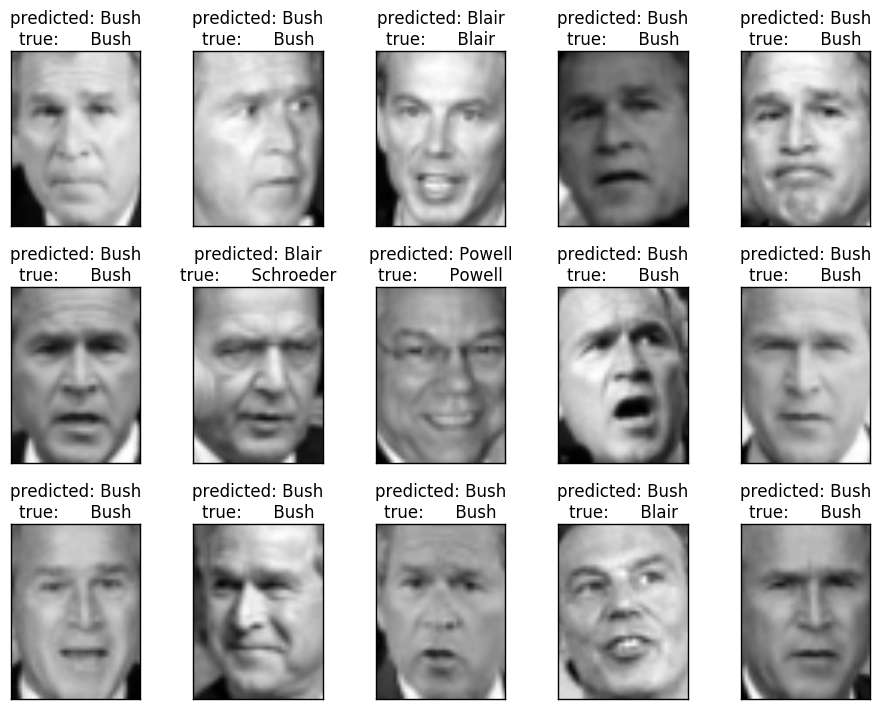

In [14]:
# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

## Time to tackle the quizzes!

Now that you've worked through this notebook, you should have answers to the some of the quizzes in the PCA mini-project. However, you may need to write additional code for some of the questions we've yet to answer. If you get stuck, a good place to start is the `sklearn` documentation. Good luck!

### We could have run the same classifier over the raw images as well. If you feel inclined, you can repeat the steps to find the optimum SVC model using GridSearch and compare its results with the the results above. 

Before you start on that, you may want to take a moment to think about what you might expect.

Does one of the two methods predict classes more reliably?

Does one of the two methods run significantly more quickly?